In [1]:
from weavepy import *

In [26]:
# Parameters
## Climate
climate_variable = "2m_temperature"
climate_variable_comparison = '<=' # '<', '<=', '>', or '>='
climate_variable_threshold = 0 # Number in units of variable
## Energy 
energy_variable = "solar_generation_capacity_factor"
energy_variable_comparison = '<' # '<', '<=', '>', or '>='
energy_variable_threshold = 0.5 # Number in units of variable
##Geography
country = "FR"

In [27]:
# Load data
climate = {}
period = "historical"
climate[period] = get_data(variable=climate_variable, period=period, verbose = False)[country]
period = "future"
for model in ["cmcc_cm2_sr5", "mpi_esm1_2_hr", "ec_earth3"]:
    climate[model] = get_data(variable=climate_variable, period=period, model = model, verbose = False)[country]

In [28]:
# Load data
energy = {}
period = "historical"
energy[period] = get_data(variable=energy_variable, period=period, verbose = False)[country]
period = "future"
for model in ["cmcc_cm2_sr5", "mpi_esm1_2_hr", "ec_earth3"]:
    energy[model] = get_data(variable=energy_variable, period=period, model = model, verbose = False)[country]

In [29]:
# Aggregate
climate_daily = {}
for a in ["historical", "cmcc_cm2_sr5", "mpi_esm1_2_hr", "ec_earth3"]:
    climate_daily[a] = climate[a].groupby(climate[a].index.floor('d')).mean()
energy_daily = {}
for a in ["historical", "cmcc_cm2_sr5", "mpi_esm1_2_hr", "ec_earth3"]:
    energy_daily[a] = energy[a].groupby(energy[a].index.floor('d')).mean()

In [30]:
# Identify problematic events
pb_days = {}
for a in ["historical", "cmcc_cm2_sr5", "mpi_esm1_2_hr", "ec_earth3"]:
    # Climate condition
    if climate_variable_comparison == '<':
        condition1 = climate_daily[a] < climate_variable_threshold
    elif climate_variable_comparison == '<=':
        condition1 = climate_daily[a] <= climate_variable_threshold
    elif climate_variable_comparison == '>':
        condition1 = climate_daily[a] > climate_variable_threshold
    elif climate_variable_comparison == '>=':
        condition1 = climate_daily[a] >= climate_variable_threshold

    # Energy condition
    if energy_variable_comparison == '<':
        condition2 = energy_daily[a] < energy_variable_threshold
    elif energy_variable_comparison == '<=':
        condition2 = energy_daily[a] <= energy_variable_threshold
    elif energy_variable_comparison == '>':
        condition2 = energy_daily[a] > energy_variable_threshold
    elif energy_variable_comparison == '>=':
        condition2 = energy_daily[a] >= energy_variable_threshold

    pb_days[a] = condition1 & condition2

In [36]:
# Identify events
events = {}
for a in ["historical", "cmcc_cm2_sr5", "mpi_esm1_2_hr", "ec_earth3"]:
    events[a] = find_events(pb_days[a])

In [47]:
# period length
period_len = {}
for a in ["historical", "cmcc_cm2_sr5", "mpi_esm1_2_hr", "ec_earth3"]:
    period_len[a] = len(np.unique(climate[a].index.year))

(0.0, 366.0)

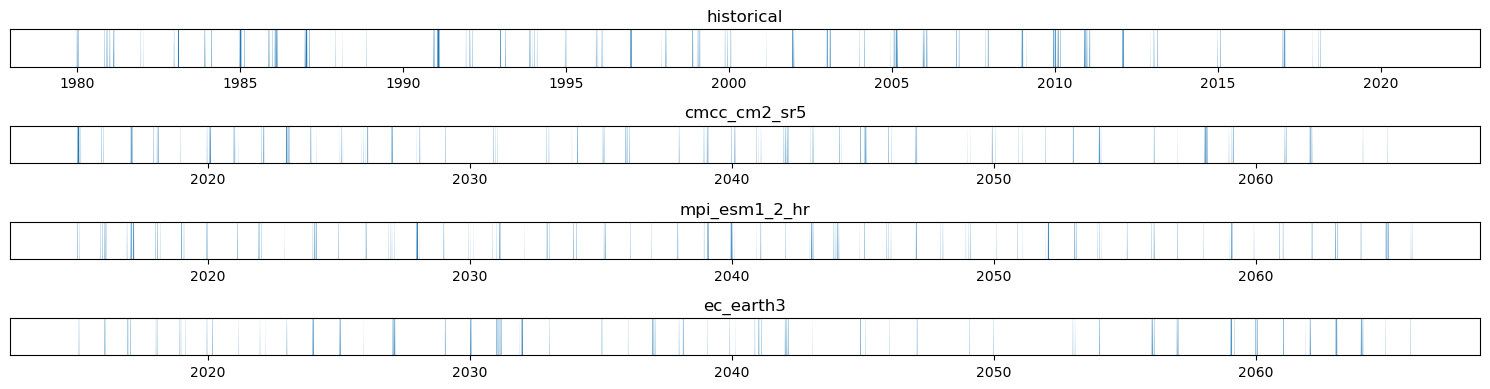

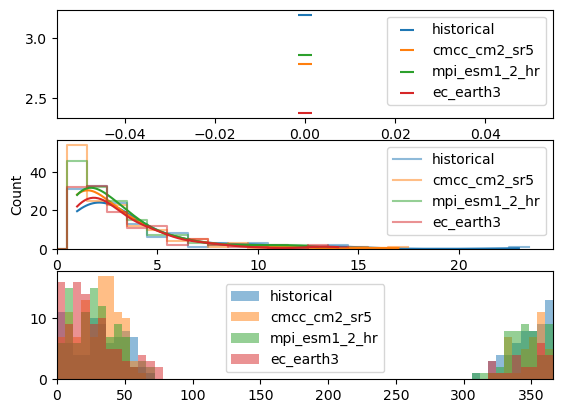

In [62]:
# Plot
## Plot individual events
fig, axs = plt.subplots(len(pb_days), figsize = [15,4])
for i, a in enumerate(pb_days):
    axs[i].fill_between(pb_days[a].index, np.where(pb_days[a], 1, 0),)
    axs[i].set_ylim(0.1,0.9)
    axs[i].set_yticks([])
    axs[i].set_title(a)
fig.tight_layout()

## Statistics
fig, axs = plt.subplots(3)
### Number of events
for a in pb_days:
    axs[0].scatter([0], [len(events[a]) / period_len[a]], label = a, marker = '_', s = 100)
axs[0].legend()

### Duration of events
for a in pb_days:
    duration = [len(event) for event in events[a]]
    sns.histplot(duration, label = a, ax = axs[1], kde = True, bins = np.arange(-0.5,max(duration) + 1), fill = False, element = "step", alpha = 0.5)
axs[1].set_xlim(0)
axs[1].legend()

### Seasonnality of the events
for a in pb_days:
    doys = [event[0].dayofyear for event in events[a]]
    axs[2].hist(doys, alpha = 0.5, label = a, bins = np.arange(0, 366+1, 6))
axs[2].legend()
axs[2].set_xlim(0, 366)